In [ ]:
!pip install -U git+https://github.com/keras-team/keras git+https://github.com/keras-team/keras-applications

In [1]:
import tensorflow as tf
from tensorflow import keras
keras.__version__, tf.__version__

('2.4.0', '2.3.1')

In [1]:
import pandas as pd
import os,shutil,math,sys
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import ImageDraw
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [3]:
#learning rate scheduler
#Drop based LR Scheduler- LearningRate = InitialLearningRate * DropRate^floor(Epoch / EpochDrop)
def step_decay(epoch):
    initial_lrate=0.1
    drop=0.6
    epochs_drop = 3.0
    lrate= initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop)) 
    return lrate

In [4]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [28]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "histopathologic_cancer_detector.h5"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
ROC_PLOT_FILE = "roc.png"
INPUT_DIR = 'C:/Users/91730/Documents/Histopathologic Cancer Detection/Cancer_Detection/input/'
SAMPLE_COUNT = 60000
TESTING_BATCH_SIZE = 57458

In [6]:
training_dir = INPUT_DIR + 'train/'

df = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})

df['id'] = df.path.map(lambda x: x.split('/')[7].split('\\')[1].split('.')[0])

labels = pd.read_csv(INPUT_DIR + 'train_labels.csv')

df = df.merge(labels,on='id')

negative_values = df[df.label == 0].sample(SAMPLE_COUNT)
positive_values = df[df.label == 1].sample(SAMPLE_COUNT)

df = pd.concat([negative_values,positive_values]).reset_index()

df = df[['path','id','label']]
df['image'] = df['path'].map(imread)





In [7]:
train_path = '../training'
val_path = '../validation'


for directory in [train_path,val_path]:
    for sub_directory in ['0','1']:
        path = os.path.join(directory,sub_directory)
        os.makedirs(path,exist_ok=True)
        
train,val = train_test_split(df,train_size=0.8,stratify=df['label'])
df.set_index('id',inplace=True)

for images_paths in [(train,train_path),(val,val_path)]:
    images = images_paths[0]
    path = images_paths[1]
    for image in images['id'].values:
        file_name = image + '.tif'
        label = str(df.loc[image,'label'])
        destination = os.path.join(path,label,file_name)
        if not os.path.exists(destination):
            source = os.path.join(INPUT_DIR + 'train',file_name)
            shutil.copyfile(source,destination)

In [8]:
train_augs = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    zoom_range=0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    channel_shift_range=0.1
)


val_augs = ImageDataGenerator(rescale=1./255)

train_gen = train_augs.flow_from_directory(
    train_path,
    target_size=(150,150),
    batch_size=64,
    class_mode='binary')

val_gen = val_augs.flow_from_directory(
    val_path,
    target_size=(150,150),
    batch_size=64,
    class_mode='binary')
print(train_gen.class_indices)

Found 216384 images belonging to 2 classes.
Found 131318 images belonging to 2 classes.
{'0': 0, '1': 1}


In [9]:
base_model = InceptionV3(include_top = False,
                  input_shape = (150,150,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
#last_layer=base_model.get_layer('add_14')
last_output=base_model.output

x = Flatten()(last_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)                  
x = Dense  (1, activation='sigmoid')(x) 

model = Model( base_model.input, x) 



In [11]:
#Callbacks
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=None,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [12]:
#Two optimizers options
opt = SGD(lr=0.0001, momentum=0.9)
opt1 = Adam(lr=2e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt1,
    metrics=['accuracy']
)
    
history = model.fit_generator(
    train_gen, 
    steps_per_epoch  = 3000, 
    validation_data  = val_gen,
    validation_steps = 1400,
    epochs = 30, 
    verbose = 1,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
   1/3000 [..............................] - ETA: 0s - loss: 1.2979 - accuracy: 0.4062WARNING:tensorflow:From C:\Users\91730\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
3000/3000 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.8138
Epoch 00001: val_loss improved from inf to 0.35789, saving model to .\base.model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: .\base.model\assets
3000/3000 [==============================] - 1256s 419ms/step - loss: 

Validation Accuracy: [0.8611830472946167]


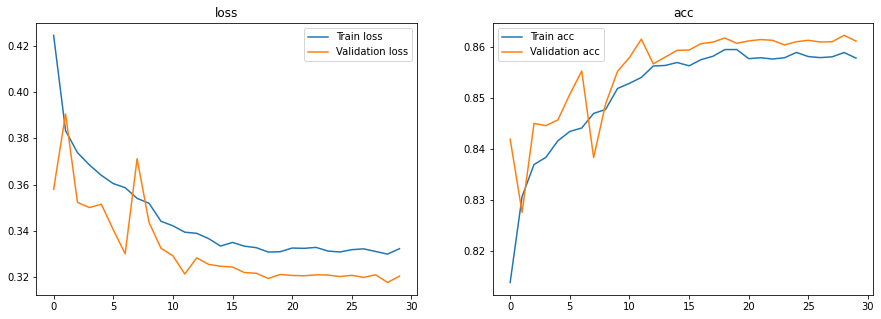

In [18]:
show_final_history(history)
print("Validation Accuracy: " + str(history.history['val_accuracy'][-1:]))

Found 131318 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
2052/2052 [==============================] - 199s 97ms/step


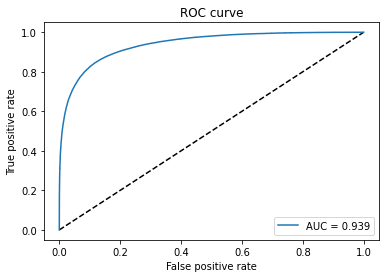

In [15]:
roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                                  target_size=(150,150),
                                                                                  batch_size=64,
                                                                                  class_mode='binary',
                                                                                  shuffle=False)
predictions = model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=1)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()

In [80]:
finaldf = pd.DataFrame()

test_dir = INPUT_DIR
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=(150,150),
        shuffle = False,
        class_mode='binary',
        batch_size=32)
filenames = test_generator.filenames
nb_samples = len(filenames)
finaldf['id'] = filenames
prediction = model.predict_generator(test_generator,steps = np.ceil(nb_samples/32))

finaldf['label'] = predictions
finaldf.to_csv(INPUT_DIR+'test_submission.csv')
print('test_submission.csv file saved.')
test_generator.reset()




Found 57458 images belonging to 1 classes.
test_submission.csv file saved.
